In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';', index_col = 0)

In [3]:
df.head(3)

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0


In [4]:
# проверим uid на наличие дубликатов
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


#### A/A - test

  0%|          | 0/1000 [00:00<?, ?it/s]

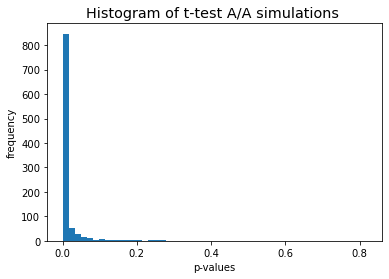

FPR is: 0.926


In [6]:
simulations = 1000
n_s = 1000
res = []

# запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 0')['purchase'].sample(n_s, replace = False).values # выборки без повторений
    s2 = df.query('experimentVariant == 1')['purchase'].sample(n_s, replace = False).values # выборки без повторений
    res.append(sp.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

# визуализация
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# проверяем, что количество ложноположительных случаев не превышает альфа
fpr = sum(np.array(res) < 0.05) / simulations
print('FPR is:', fpr)

Очевидно, система сплитования работает некорректно. Попробуем разобраться почему. 

In [10]:
# проверим распределение значений purchase по группам
print('Purchases distribution:')
pd.concat([df.query('experimentVariant == 0').purchase.value_counts().rename('experimentVariant = 0'), \
           df.query('experimentVariant == 1').purchase.value_counts().rename('experimentVariant = 1')], axis = 1)

Purchases distribution:


,experimentVariant = 0,experimentVariant = 1
0,61591,60513
1,1511,3403


In [11]:
# проверим распределение пользователей разных версий по группам
print('purchases.version destribution:')
pd.concat([df.query('experimentVariant == 0').version.value_counts().rename('experimentVariant = 0'), \
           df.query('experimentVariant == 1').version.value_counts().rename('experimentVariant = 1')], axis=1)

purchases.version destribution:


,experimentVariant = 0,experimentVariant = 1
v2.8.0,41283,41552
v2.9.0,11921,12033
v3.8.0.0,5694,6110
v3.7.4.0,4204,4221


In [12]:
# посчитаем конверсию в покупку, группируя по варианту и версии мобильного приложения
df.groupby(['version', 'experimentVariant'], as_index = False) \
    .agg({'purchase': ['mean', 'count']})

version experimentVariant  purchase       
                                   mean  count
0    v2.8.0                 0  0.000993  41283
1    v2.8.0                 1  0.045606  41552
2    v2.9.0                 0  0.074658  11921
3    v2.9.0                 1  0.071304  12033
4  v3.7.4.0                 0  0.059943   4204
5  v3.7.4.0                 1  0.063018   4221
6  v3.8.0.0                 0  0.057604   5694
7  v3.8.0.0                 1  0.062848   6110

По всей видимости, аномалия находится в версии v2.8.0, поскольку показатель конверсии там слишком низкий.
Выясним, могут ли такие различия в показателях конверсии внутри одной версии мобильного приложения быть случайными? Для этого сравним средние двух групп внутри кажой версии мобильного приложения на наличие статистически значимых различий.

#### v2.8.0

In [13]:
v2_8_0_variant_0 = df.query('experimentVariant == 0 and version == "v2.8.0"').purchase
v2_8_0_variant_1 = df.query('experimentVariant == 1 and version == "v2.8.0"').purchase

sp.ttest_ind(v2_8_0_variant_0, v2_8_0_variant_1)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

#### v2.9.0

In [14]:
v2_9_0_variant_0 = df.query('experimentVariant == 0 and version == "v2.9.0"').purchase
v2_9_0_variant_1 = df.query('experimentVariant == 1 and version == "v2.9.0"').purchase

sp.ttest_ind(v2_9_0_variant_0, v2_9_0_variant_1)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

#### v3.7.4.0

In [15]:
v3_7_4_0_variant_0 = df.query('experimentVariant == 0 and version == "v3.7.4.0"').purchase
v3_7_4_0_variant_1 = df.query('experimentVariant == 1 and version == "v3.7.4.0"').purchase

sp.ttest_ind(v3_7_4_0_variant_0, v3_7_4_0_variant_1)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

#### v3.8.0.0	

In [17]:
v3_8_0_0_variant_0 = df.query('experimentVariant == 0 and version == "v3.8.0.0"').purchase
v3_8_0_0_variant_1 = df.query('experimentVariant == 1 and version == "v3.8.0.0"').purchase

sp.ttest_ind(v3_8_0_0_variant_0, v3_8_0_0_variant_1)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Т-тест говорит от том, что средние показатели уровня конверсии в версии v2.8.0 статистически значимо различаются в двух группах. Поэтому представляется оправданным исключить версию с pvalue < 0.05 из основного датафрейма.

In [18]:
fixed_df = df.query('version != "v2.8.0"')

Повторим А/А тест на обрезанных данных.

  0%|          | 0/1000 [00:00<?, ?it/s]

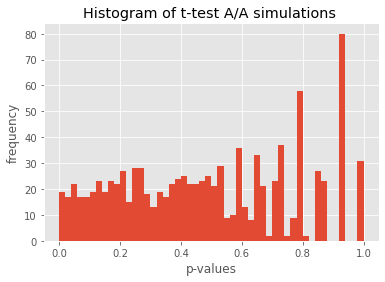

FPR is: 0.041


In [19]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = fixed_df.query('experimentVariant == 0')['purchase'].sample(n_s, replace = False).values # выборки без повторений
    s2 = fixed_df.query('experimentVariant == 1')['purchase'].sample(n_s, replace = False).values # выборки без повторений
    res.append(sp.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
fpr = sum(np.array(res) < 0.05) / simulations
print('FPR is:', fpr)

Теперь система сплитования работает корректно!

#### Выводы

- Было проведено А/А тестирование, показавшее наличие проблем в системе сплитования (сильная правая асимметрия в распределении p-values, FPR > 0.05)
- Был проведён post-hoc анализ для обнаружения причины проблем в системе сплитования
- Были обнаружены аномальные показатели конверсии в покупку для пользователей с версией мобильного приложения 'v2.8.0'
- После удаления аномальных данных и повторного проведения А/А теста было обнаружено, что система сплитования работает корректно (равномерное распределение p-values, FPR < 0.05)